# Time Series Challenge

### Using a different time series data set (either from [FRED](https://fred.stlouisfed.org/) or elsewhere, go about the process of time series modeling. Specifically generate the following things:

1. Plot the time series, along with any logical or necessary differences to get a stationary dataset
1. Generate and interpret a PACF for the time series (and/or its differences)
1. Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data
1. Finally choose one specification and make the case for that as a logical model for your dataset.

This should come in the form of a notebook with the necessary prose to explain your process. Remember to use the tools of text, visuals, and analysis to tell a clear and concise story with your data.

### Dependancies

In [1]:
import pandas as pd
import scipy.stats as st
import collections
import datetime as dt
import time
import numpy as np

from datetime import datetime as dt
from datetime import timedelta as td

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Import

I will be using the Covid-19 time series dataset that can be found [here](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset)

In [2]:
dataC = pd.read_csv('Data/time_series_covid_19_confirmed_US.csv')
dataD = pd.read_csv('Data/time_series_covid_19_deaths_US.csv')

In [3]:
data = pd.concat(
    [dataC, dataD],
    keys=['cases', 'deaths'],
    names=['count_type', 'locationID']
).reset_index(level=['count_type', 'locationID']).sort_values(['Province_State', 'count_type']).reset_index(drop=True)
data = data.drop(columns=['locationID', 'Country_Region', 'Lat', 'Long_', 'iso2', 'iso3', 'code3', 'FIPS', 'UID'])
colreorder = ['count_type']
loccols = ['Province_State']
data = data[colreorder + loccols + [col for col in data.columns if (col not in colreorder) & (col not in loccols)]]
data = data.fillna('N/A')
data = data.groupby(['Province_State', 'count_type']).sum().reset_index()
data.head()

,Province_State,count_type,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20
0,Alabama,cases,0,0,0,0,0,0,0,0,...,2169,2328,2703,2947,3217,3563,3734,3953.0,4075,4345
1,Alabama,deaths,0,0,0,0,0,0,0,0,...,64,66,70,80,92,93,99,114.0,118,133
2,Alaska,cases,0,0,0,0,0,0,0,0,...,213,226,235,246,257,272,277,285.0,293,300
3,Alaska,deaths,0,0,0,0,0,0,0,0,...,6,7,7,7,8,8,8,9.0,9,9
4,American Samoa,cases,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0


In [4]:
newdf = pd.melt(data, id_vars=['Province_State', 'count_type'], value_name='count', var_name='Date')
newdf['Date'] = pd.to_datetime(newdf['Date'])
display(newdf.shape)
for location in newdf['Province_State'].unique():
    datacheck = newdf[
        (newdf['Province_State'] == location) &
        (newdf['count_type'] == 'cases')
    ]
    if datacheck['count'].sum() < 1:
        newdf = newdf[newdf['Province_State'] != location]
        display(location)
display(newdf.shape)

(9976, 4)

'American Samoa'

(9804, 4)

In [5]:
newdf.head()

,Province_State,count_type,Date,count
0,Alabama,cases,2020-01-22,0.0
1,Alabama,deaths,2020-01-22,0.0
2,Alaska,cases,2020-01-22,0.0
3,Alaska,deaths,2020-01-22,0.0
6,Arizona,cases,2020-01-22,0.0


### Plot the time series, along with any logical or necessary differences to get a stationary dataset

In [14]:
calicases = newdf[
    (newdf['Province_State'] == 'California')
    & (newdf['count_type'] == 'cases')
                 ].reset_index(drop=True)
calicases['diff_1'] = calicases['count'] - calicases['count'].shift()
calicases['diff_2'] = calicases['diff_1'] - calicases['diff_1'].shift()
calicases = calicases.dropna()

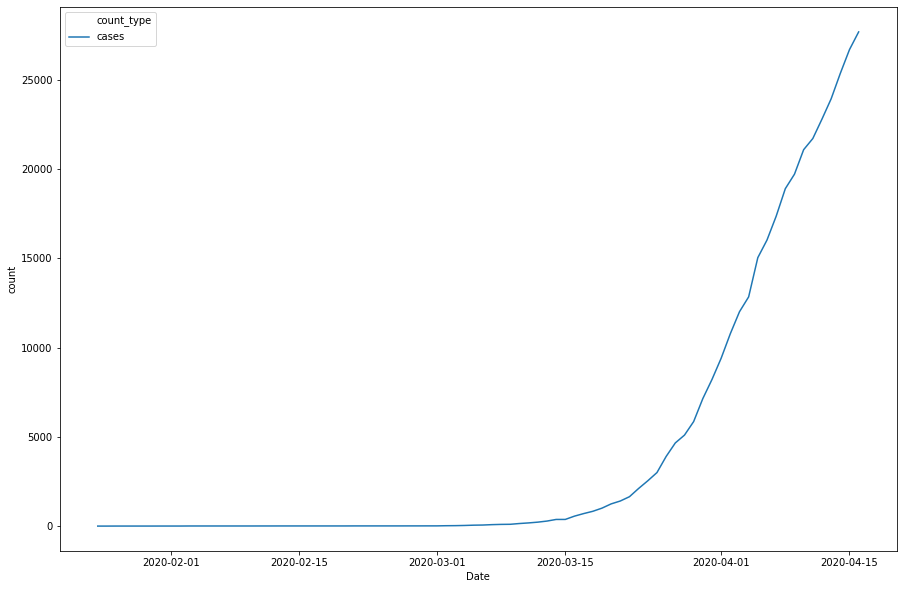

In [15]:
plt.figure(figsize=[15, 10])
sns.lineplot(x='Date', y='count', hue='count_type', data=calicases)
plt.show()

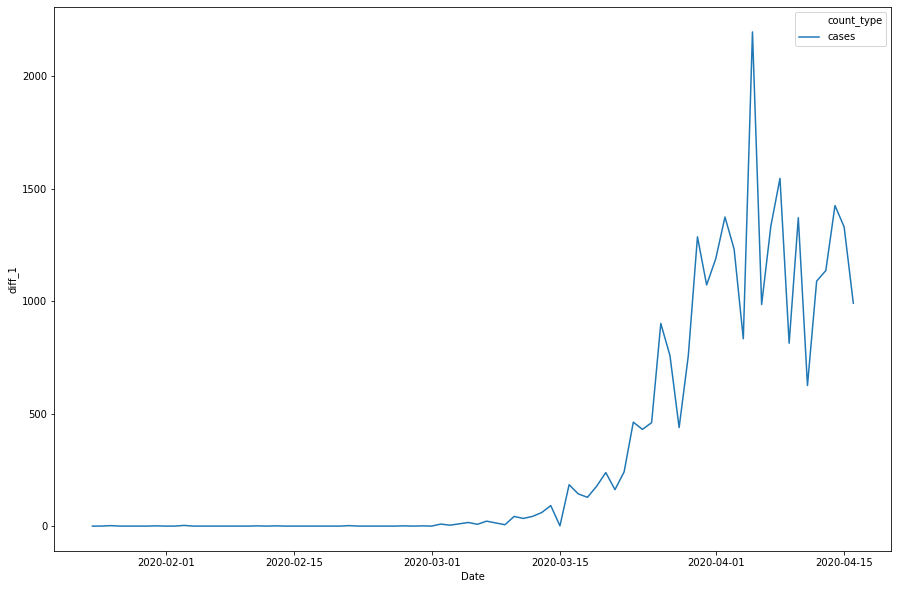

In [16]:
plt.figure(figsize=[15, 10])
sns.lineplot(x='Date', y='diff_1', hue='count_type', data=calicases)
plt.show()

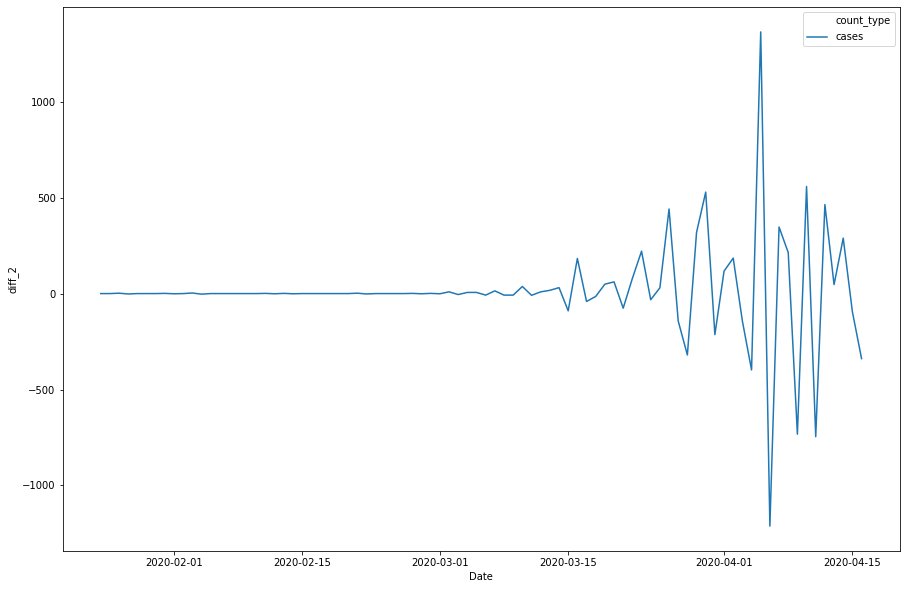

In [17]:
plt.figure(figsize=[15, 10])
sns.lineplot(x='Date', y='diff_2', hue='count_type', data=calicases)
plt.show()

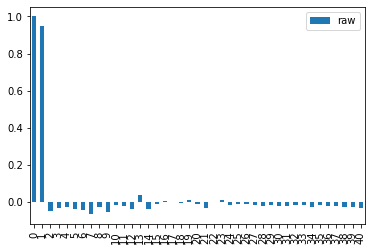

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


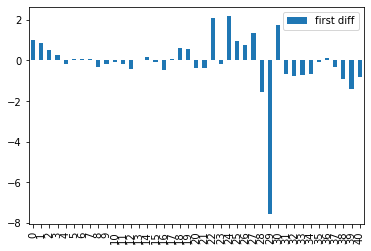

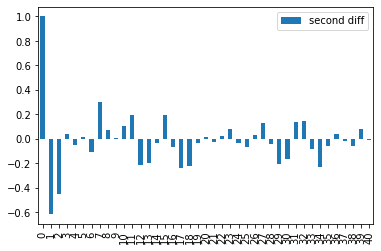

In [18]:
x_acf = pd.DataFrame(pacf(calicases['count']))
x_acf.plot(kind='bar')
plt.legend(['raw'])
plt.show()

x_acf = pd.DataFrame(pacf(calicases['diff_1']))
x_acf.plot(kind='bar')
plt.legend(['first diff'])
plt.show()

x_acf = pd.DataFrame(pacf(calicases['diff_2']))
x_acf.plot(kind='bar')
plt.legend(['second diff'])
plt.show()

### Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data

In [19]:
def build_arimamodel(df, col, arimaorder=(1,1,1)):
    model = ARIMA(df[col], order=arimaorder)
    model_fit = model.fit()
    display(f"ARIMA model of order: {arimaorder}",
            model_fit.summary(),
            pd.DataFrame(model_fit.resid.describe(), 
                         columns=['Residual Description'])
    )
    return model_fit

In [33]:
test_arima = [
    (1,2,1),
    (2,2,2),
    (3,2,1),
    (2,2,3),
    (4,2,4)
]
for tpl in test_arima:
    model = build_arimamodel(calicases, 'count', tpl)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


'ARIMA model of order: (1, 2, 1)'

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.count   No. Observations:                   82
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -552.385
Method:                       css-mle   S.D. of innovations            202.914
Date:                Sat, 20 Jun 2020   AIC                           1112.769
Time:                        06:40:35   BIC                           1122.396
Sample:                             2   HQIC                          1116.634
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             14.8227      8.623      1.719      0.090      -2.079      31.724
ar.L1.D2.count    -0.4004      0.125     -3.211      0.002      -0.645      -0.156
ma.L1.D2.count    -0.4690      0.102     -4.596      0.000      -0.669      -0.269
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.4976           +0.0000j            2.4976            0.5000
MA.1            2.1324           +0.0000j            2.1324            0.0000
-----------------------------------------------------------------------------
"""

,Residual Description
count,82.000000
mean,-0.436077
std,204.167282
min,-571.192402
25%,-39.389952
50%,-37.310597
75%,8.609834
max,969.636100


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


'ARIMA model of order: (2, 2, 2)'

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.count   No. Observations:                   82
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -548.118
Method:                       css-mle   S.D. of innovations            192.147
Date:                Sat, 20 Jun 2020   AIC                           1108.237
Time:                        06:40:35   BIC                           1122.677
Sample:                             2   HQIC                          1114.034
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             15.0580      8.890      1.694      0.094      -2.367      32.483
ar.L1.D2.count    -1.3110      0.127    -10.350      0.000      -1.559      -1.063
ar.L2.D2.count    -0.5639      0.115     -4.919      0.000      -0.789      -0.339
ma.L1.D2.count     0.4730      0.141      3.355      0.001       0.197       0.749
ma.L2.D2.count    -0.2825      0.125     -2.265      0.026      -0.527      -0.038
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1624           -0.6498j            1.3317           -0.4189
AR.2           -1.1624           +0.6498j            1.3317            0.4189
MA.1           -1.2221           +0.0000j            1.2221            0.5000
MA.2            2.8967           +0.0000j            2.8967            0.0000
-----------------------------------------------------------------------------
"""

,Residual Description
count,82.000000
mean,-0.371715
std,193.342608
min,-503.477626
25%,-36.978398
50%,-35.526398
75%,-10.461618
max,976.368268


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


'ARIMA model of order: (3, 2, 1)'

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.count   No. Observations:                   82
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -549.239
Method:                       css-mle   S.D. of innovations            195.034
Date:                Sat, 20 Jun 2020   AIC                           1110.479
Time:                        06:40:36   BIC                           1124.919
Sample:                             2   HQIC                          1116.276
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             15.6115      9.202      1.696      0.094      -2.425      33.648
ar.L1.D2.count     0.0920      0.200      0.460      0.647      -0.300       0.484
ar.L2.D2.count     0.4431      0.108      4.105      0.000       0.232       0.655
ar.L3.D2.count     0.4648      0.129      3.609      0.001       0.212       0.717
ma.L1.D2.count    -1.0000      0.001  -1771.243      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           -0.0000j            1.0000           -0.0000
AR.2           -0.9766           -1.0943j            1.4667           -0.3660
AR.3           -0.9766           +1.0943j            1.4667            0.3660
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

,Residual Description
count,82.000000
mean,-1.759612
std,196.234432
min,-617.137607
25%,-37.507030
50%,-36.491909
75%,-5.917237
max,899.115113


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


'ARIMA model of order: (2, 2, 3)'

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.count   No. Observations:                   82
Model:                 ARIMA(2, 2, 3)   Log Likelihood                -547.664
Method:                       css-mle   S.D. of innovations            191.057
Date:                Sat, 20 Jun 2020   AIC                           1109.329
Time:                        06:40:37   BIC                           1126.176
Sample:                             2   HQIC                          1116.093
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             15.1719      9.603      1.580      0.118      -3.649      33.993
ar.L1.D2.count    -1.1512      0.225     -5.127      0.000      -1.591      -0.711
ar.L2.D2.count    -0.4186      0.216     -1.934      0.057      -0.843       0.006
ma.L1.D2.count     0.2866      0.241      1.187      0.239      -0.187       0.760
ma.L2.D2.count    -0.2933      0.143     -2.048      0.044      -0.574      -0.013
ma.L3.D2.count     0.1671      0.168      0.997      0.322      -0.161       0.495
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3751           -0.7057j            1.5456           -0.4245
AR.2           -1.3751           +0.7057j            1.5456            0.4245
MA.1           -1.1673           -0.0000j            1.1673           -0.5000
MA.2            1.4615           -1.7295j            2.2643           -0.1383
MA.3            1.4615           +1.7295j            2.2643            0.1383
-----------------------------------------------------------------------------
"""

,Residual Description
count,82.000000
mean,-0.231882
std,192.246494
min,-517.761695
25%,-34.579038
50%,-33.201897
75%,-8.998899
max,940.806528


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


'ARIMA model of order: (4, 2, 4)'

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.count   No. Observations:                   82
Model:                 ARIMA(4, 2, 4)   Log Likelihood                -544.795
Method:                       css-mle   S.D. of innovations            179.575
Date:                Sat, 20 Jun 2020   AIC                           1109.590
Time:                        06:40:38   BIC                           1133.657
Sample:                             2   HQIC                          1119.252
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.5712     10.125      1.637      0.106      -3.274      36.416
ar.L1.D2.count    -0.1724      0.219     -0.788      0.433      -0.601       0.256
ar.L2.D2.count     0.2548      0.169      1.505      0.137      -0.077       0.587
ar.L3.D2.count    -0.2990      0.168     -1.780      0.079      -0.628       0.030
ar.L4.D2.count    -0.4191      0.136     -3.085      0.003      -0.685      -0.153
ma.L1.D2.count    -0.7856      0.227     -3.461      0.001      -1.231      -0.341
ma.L2.D2.count    -0.1218      0.205     -0.594      0.554      -0.524       0.280
ma.L3.D2.count     0.8453      0.173      4.878      0.000       0.506       1.185
ma.L4.D2.count    -0.1061      0.197     -0.538      0.592      -0.493       0.281
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8021           -0.8565j            1.1735           -0.1302
AR.2            0.8021           +0.8565j            1.1735            0.1302
AR.3           -1.1588           -0.6246j            1.3164           -0.4213
AR.4           -1.1588           +0.6246j            1.3164            0.4213
MA.1            0.7372           -0.6757j            1.0000           -0.1181
MA.2            0.7372           +0.6757j            1.0000            0.1181
MA.3           -1.2217           -0.0000j            1.2217           -0.5000
MA.4            7.7109           -0.0000j            7.7109           -0.0000
-----------------------------------------------------------------------------
"""

,Residual Description
count,82.000000
mean,-0.338567
std,183.098930
min,-588.024791
25%,-37.999103
50%,-31.021518
75%,-8.815944
max,735.337044


<span style="color:blue">Based on the initial analysis, we know that second differential is required for data stationarity, so our set of testing arima models will have a consistent 'I' component of two.  I played with the AR and MA variables and based on the AIC score of each model, we can see that ARIMA(2,2,2) performed the best with the lowest AIC score of 1108.</span>

### Finally choose one specification and make the case for that as a logical model for your dataset

In [34]:
model = build_arimamodel(calicases, 'count', (2,2,2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


'ARIMA model of order: (2, 2, 2)'

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.count   No. Observations:                   82
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -548.118
Method:                       css-mle   S.D. of innovations            192.147
Date:                Sat, 20 Jun 2020   AIC                           1108.237
Time:                        06:40:45   BIC                           1122.677
Sample:                             2   HQIC                          1114.034
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             15.0580      8.890      1.694      0.094      -2.367      32.483
ar.L1.D2.count    -1.3110      0.127    -10.350      0.000      -1.559      -1.063
ar.L2.D2.count    -0.5639      0.115     -4.919      0.000      -0.789      -0.339
ma.L1.D2.count     0.4730      0.141      3.355      0.001       0.197       0.749
ma.L2.D2.count    -0.2825      0.125     -2.265      0.026      -0.527      -0.038
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1624           -0.6498j            1.3317           -0.4189
AR.2           -1.1624           +0.6498j            1.3317            0.4189
MA.1           -1.2221           +0.0000j            1.2221            0.5000
MA.2            2.8967           +0.0000j            2.8967            0.0000
-----------------------------------------------------------------------------
"""

,Residual Description
count,82.000000
mean,-0.371715
std,193.342608
min,-503.477626
25%,-36.978398
50%,-35.526398
75%,-10.461618
max,976.368268


<span style="color:blue">Based on the p values of the coefficients, we can tell that the constant value is not significant which is expected in higher diff models.  While all the remaining coefficients are significant the autoregressive factors are more consistently significant.</span>